In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取CSV文件，不指定数据类型，让pandas自动识别
data = pd.read_csv('preprocess2.csv')

# 处理缺失值（填充或删除含有缺失值的行）
data = data.dropna()
data = data.tail(10000)

# 将分类变量转化为虚拟变量（独热编码），排除目标变量
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 定义需要预测的目标变量
target = '紫外线（指数）'
results = {}

# 设置交叉验证的折数和参数范围
kf = KFold(n_splits=5, shuffle=True, random_state=1)
n_estimators_list = [50, 100, 150, 200]  # 不同的树的数量

# 将当前目标变量y，其余作为特征X
X = data.drop(columns=[target])
y = data[target]

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化处理特征
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# 存储不同n_estimators的分数
scores = []

# 对每个树的数量进行交叉验证
for n_estimators in n_estimators_list:
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    scores.append(cross_val_score(rf_regressor, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean())

# 找到最佳分数和对应的n_estimators
best_score_index = scores.index(max(scores))
best_n_estimators = n_estimators_list[best_score_index]
best_score = max(scores) * -1  # 因为分数是负的MSE

# 使用最佳n_estimators训练模型
best_rf_regressor = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
best_rf_regressor.fit(X_train, y_train)


# 进行预测
y_pred = best_rf_regressor.predict(X_test)
y_train_pred = best_rf_regressor.predict(X_train)

# 计算训练集和测试集的MSE、RMSE、MAE和R²分数
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = best_rf_regressor.score(X_train, y_train)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = best_rf_regressor.score(X_test, y_test)

results = {
    '最佳n_estimators':best_n_estimators,
    '最佳MSE': best_score,
    '训练集MSE': train_mse,
    '训练集RMSE': train_rmse,
    '训练集MAE': train_mae,
    '训练集R²分数': train_r2,
    '测试集MSE': test_mse,
    '测试集RMSE': test_rmse,
    '测试集MAE': test_mae,
    '测试集R²分数': test_r2
}
# 打印结果
print(f"\n{target}的评价指标:")
for metric, value in results.items():
    print(f"{metric}: {value}")

# 检查数据是否有异常值
print("\n数据描述统计:")
print(data.describe())

# 检查训练和测试集的分布
print("\n训练集和测试集的分布差异:")
print("训练集的形状:", X_train.shape)
print("测试集的形状:", X_test.shape)



紫外线（指数）的评价指标:
最佳n_estimators: 200
最佳MSE: 0.600378928997813
训练集MSE: 0.1494488940817859
训练集RMSE: 0.3865862052398998
训练集MAE: 0.12222773330315516
训练集R²分数: 0.9814524284365869
测试集MSE: 0.41872232992307035
测试集RMSE: 0.6470875751573896
测试集MAE: 0.24252917027417026
测试集R²分数: 0.9473588051094726

数据描述统计:
               区域名称         阵风（级）       能见度（公里）     最大湿度（百分比）            风向  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       4.502700      4.441900     15.528300     86.763500      3.952900   
std        1.708943      0.868504      3.702914      7.039071      2.430776   
min        2.000000      3.000000      5.000000     35.000000      1.000000   
25%        3.000000      4.000000     12.000000     85.000000      1.000000   
50%        5.000000      4.000000     15.000000     85.000000      5.000000   
75%        6.000000      5.000000     20.000000     90.000000      6.000000   
max        7.000000      9.000000     25.000000    100.000000      8.000000 

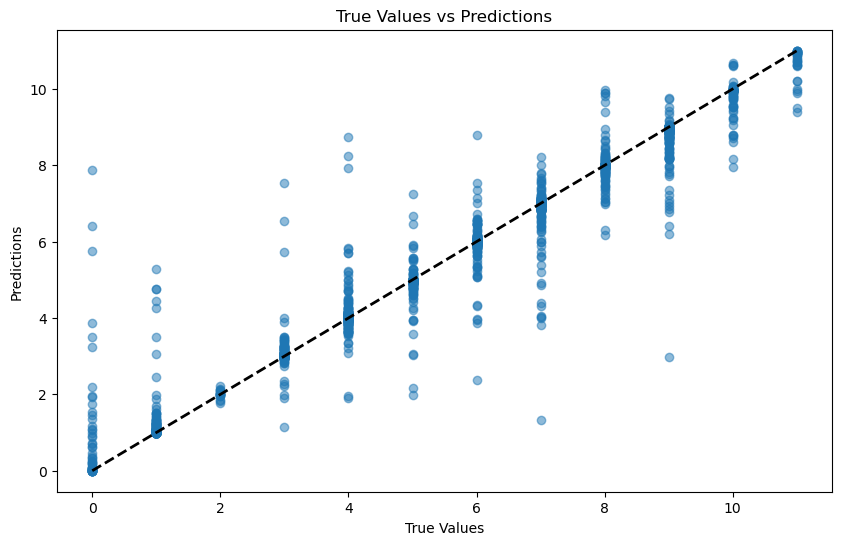

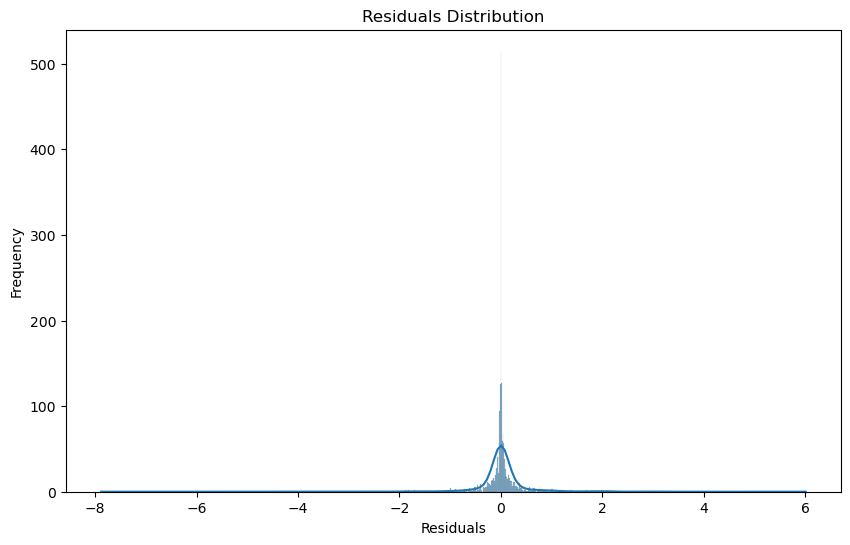

In [3]:
# 可视化回归残差
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


c:\Users\12737\Desktop\STUDY\Sophomore\DIP\exp 4\.conda\Lib\site-packages\sklearn\tree\_export.py:665: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\12737\Desktop\STUDY\Sophomore\DIP\exp 4\.conda\Lib\site-packages\sklearn\tree\_export.py:665: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\12737\Desktop\STUDY\Sophomore\DIP\exp 4\.conda\Lib\site-packages\sklearn\tree\_export.py:665: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\12737\Desktop\STUDY\Sophomore\DIP\exp 4\.conda\Lib\site-packages\sklearn\tree\_export.py:665: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\12737\Desktop\STUDY\Sophomore\DIP\exp 4\.conda\Lib\site-packages\sklear

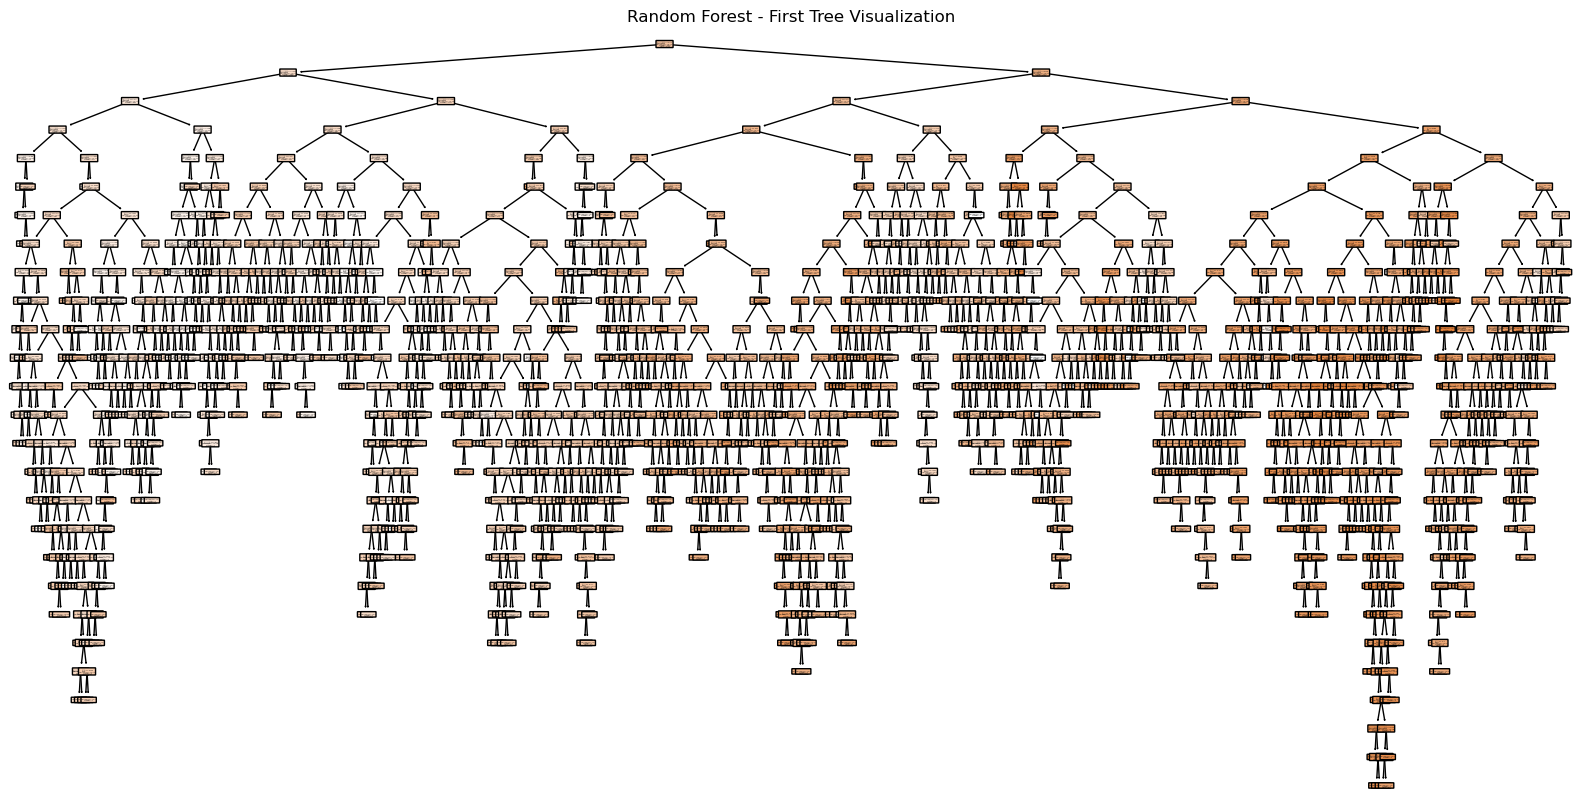

In [4]:
# 可视化随机森林中的一个决策树
plt.figure(figsize=(20, 10))
tree = best_rf_regressor.estimators_[0]
plot_tree(tree, filled=True, feature_names=X.columns, rounded=True)
plt.title('Random Forest - First Tree Visualization')
plt.show()